In [3]:
import cv2, os, shutil
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import exposure, measure, morphology, filters
import pandas as pd

In [1]:
def detect_image_content_region(img, black_threshold=20, border_percentage=0.15) -> tuple:
	"""
	Detects the main content region in a grayscale image.
	
	Args:
		img: Grayscale numpy array
		black_threshold: Pixel values below this are considered "black"
		border_percentage: Percentage of image edges to ignore
		
	Returns:
		tuple: (x, y, width, height) of content region
	"""
	# Input validation
	if img is None or not isinstance(img, np.ndarray):
		raise ValueError("Input must be a numpy array")
	
	if len(img.shape) > 2:
		raise ValueError("Input must be a grayscale image (2D array)")
		
	height, width = img.shape
	
	# Calculate border sizes to check
	border_width = int(width * border_percentage)
	border_height = int(height * border_percentage)
	
	# Create a mask of non-black regions
	content_mask = img > black_threshold
	
	# Remove border regions from consideration
	content_mask[:border_height, :] = False
	content_mask[-border_height:, :] = False
	content_mask[:, :border_width] = False
	content_mask[:, -border_width:] = False
	
	# Find bounding box of content
	rows = np.any(content_mask, axis=1)
	cols = np.any(content_mask, axis=0)
	
	# Handle case where no content is found
	if not np.any(rows) or not np.any(cols):
		return (0, 0, width, height)
	
	rmin, rmax = np.where(rows)[0][[0, -1]]
	cmin, cmax = np.where(cols)[0][[0, -1]]
	
	return (cmin, rmin, cmax-cmin, rmax-rmin)


def adaptive_content_normalize(img, debug=False):
	"""
	Normalize image content based on the detected region of interest.
	
	Args:
		img: Grayscale numpy array
		debug: Whether to display debug visualizations
		
	Returns:
		tuple: (normalized_image, diagnostic_info)
	"""
	# Input validation
	if img is None or not isinstance(img, np.ndarray):
		raise ValueError("Input must be a numpy array")
	
	if len(img.shape) > 2:
		raise ValueError("Input must be a grayscale image (2D array)")
	
	x, y, w, h = detect_image_content_region(img)
	diagnostic_info = {}
	
	# Extract content region
	content_region = img[y:y+h, x:x+w]
	
	# Calculate content region statistics
	content_pixels = content_region.flatten()
	content_mean = np.mean(content_pixels)
	content_std = np.std(content_pixels)
	non_zero_pixels = content_pixels[content_pixels > 20]

	# Adaptive normalization
	if len(non_zero_pixels) == 0 or len(non_zero_pixels) / len(content_pixels) < 0.1:
		clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
		normalized_img = clahe.apply(img)
	
	else:
		p2, p98 = np.percentile(non_zero_pixels, [2, 98])
		
		# Clip and normalize
		img_clipped = np.clip(img, p2, p98)
		normalized_img = cv2.normalize(
			img_clipped, 
			None, 
			0, 255, 
			cv2.NORM_MINMAX, 
			dtype=cv2.CV_8U
		)
	
	# Debug visualization
	if debug:
		# Diagnostic metrics
		diagnostic_info = {
			'content_region': (x, y, w, h),
			'content_mean': content_mean,
			'content_std': content_std,
			'non_zero_pixel_count': len(non_zero_pixels),
			'non_zero_pixel_ratio': len(non_zero_pixels) / len(content_pixels) if len(content_pixels) > 0 else 0
		}

		fig, axs = plt.subplots(1, 3, figsize=(15, 5))
		
		# Original image with content region
		axs[0].imshow(img, cmap='gray')
		rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
		axs[0].add_patch(rect)
		axs[0].set_title('Original Image with Content Region')
		
		# Content region
		axs[1].imshow(content_region, cmap='gray')
		axs[1].set_title('Content Region')
		
		# Normalized image
		axs[2].imshow(normalized_img, cmap='gray')
		axs[2].set_title('Normalized Image')
		
		# Add diagnostic info as text
		plt.suptitle('\n'.join([
			f"Content Mean: {content_mean:.2f}",
			f"Content Std: {content_std:.2f}",
			f"Non-Zero Pixel Ratio: {diagnostic_info['non_zero_pixel_ratio']:.2%}"
		]))
		
		plt.tight_layout()
		plt.show()
	
	return normalized_img, diagnostic_info


def image_clamping(img, thresh=0.5):
	"""
	Clamps the brightness of an image. If a pixel's brightness (sum of RGB)
	is more than `thresh` (percentage of max brightness), it's set to 100%.
	Otherwise, it's set to 0%.

	Args:
		img: Input image (numpy array - grayscale or RGB)
		thresh: Threshold percentage (0 to 1) of max brightness.
		
	Returns:
		numpy.ndarray: Clamped image as numpy array
	"""
	# Input validation
	if img is None:
		raise ValueError("Input image cannot be None")
	
	# Convert PIL Image to numpy if needed
	if isinstance(img, Image.Image):
		img_array = np.array(img, dtype=np.uint8)
	else:
		img_array = img.copy()
	
	# Handle both grayscale and RGB images
	if len(img_array.shape) == 2:
		# Grayscale image
		max_value = 255
		brightness = img_array
	elif len(img_array.shape) == 3 and img_array.shape[2] == 3:
		# RGB image
		max_value = 255 * 3
		brightness = img_array.sum(axis=-1)
	else:
		raise ValueError("Unsupported image format. Must be grayscale or RGB.")

	# Apply threshold using NumPy boolean masking
	mask = brightness > (thresh * max_value)
	
	# Create output array (same shape as input)
	if len(img_array.shape) == 2:
		# Grayscale output
		clamped_array = np.zeros_like(img_array, dtype=np.uint8)
		clamped_array[mask] = 255
	else:
		# RGB output
		clamped_array = np.zeros_like(img_array, dtype=np.uint8)
		# Set pixels above threshold to white (all channels)
		clamped_array[mask] = [255, 255, 255]  

	return clamped_array


def segment_lungs_robust(image):
	"""
	Improved robust lung segmentation that:
	1. Better focuses on dark regions (lung tissue)
	2. Better handles small or isolated regions
	3. Prevents over-segmentation
	4. Works with various lung sizes and positions
	
	Args:
		image: Grayscale numpy array
		
	Returns:
		tuple: (segmented_image, lung_mask)
	"""
	# Input validation
	if image is None or not isinstance(image, np.ndarray):
		raise ValueError("Input must be a numpy array")
	
	if len(image.shape) > 2:
		raise ValueError("Input must be a grayscale image (2D array)")
	
	# STEP 1: Initial thresholding - focus on dark regions (lungs are dark in CT)
	# More aggressive threshold for dark regions
	binary = image < 130  # Lowered threshold to better capture lung regions
	
	# STEP 2: Identify and remove background/border regions
	# Label all connected regions
	labels = measure.label(binary)
	
	# Find regions connected to the image border (these are background/external air)
	background_labels = set()
	for i in range(labels.shape[1]):
		background_labels.add(labels[0, i])
		background_labels.add(labels[-1, i])
	for i in range(labels.shape[0]):
		background_labels.add(labels[i, 0])
		background_labels.add(labels[i, -1])
	
	# Remove background regions
	for label in background_labels:
		if label != 0:  # 0 is usually the background label
			binary[labels == label] = 0
	
	# STEP 3: Clean up the binary mask
	# Remove small isolated regions - increased size threshold
	binary = morphology.remove_small_objects(binary, min_size=500)  # Increased from 200
	
	# Fill small holes
	binary = morphology.remove_small_holes(binary, area_threshold=300)  # Increased from 200
	
	# STEP 4: Extract and keep only the significant lung regions
	labels = measure.label(binary)
	props = measure.regionprops(labels)
	
	# Sort regions by area (descending)
	props.sort(key=lambda x: x.area, reverse=True)
	
	# Calculate the image area for reference
	total_image_area = image.shape[0] * image.shape[1]
	
	# Get the two largest regions that are reasonably sized (lung candidates)
	lung_mask = np.zeros_like(binary, dtype=bool)
	
	# Use stricter criteria for minimum area (1% of image)
	min_area = 0.01 * total_image_area
	
	# First pass: count valid candidates and get max area
	valid_candidates = 0
	max_area = 0
	
	for prop in props:
		if prop.area > min_area:
			valid_candidates += 1
			max_area = max(max_area, prop.area)
	
	# Check if we're missing lungs - if we have no large regions
	# or if the largest region is too small, try a different approach
	if valid_candidates == 0 or max_area < 0.03 * total_image_area:
		# Try a different threshold focused specifically on dark regions
		binary = image < 100  # More aggressive threshold for very dark regions
		binary = morphology.remove_small_objects(binary, min_size=500)
		binary = morphology.remove_small_holes(binary, area_threshold=300)
		
		# Remove border regions again
		labels = measure.label(binary)
		for i in range(labels.shape[1]):
			binary[0, i] = 0
			binary[-1, i] = 0
		for i in range(labels.shape[0]):
			binary[i, 0] = 0
			binary[i, -1] = 0
			
		binary = morphology.remove_small_objects(binary, min_size=500)
		
		# Reanalyze regions
		labels = measure.label(binary)
		props = measure.regionprops(labels)
		props.sort(key=lambda x: x.area, reverse=True)
	
	# NEW: If we still don't have good candidates, check image darkness
	# Measure average image intensity - if high, this might not even contain lungs
	avg_intensity = np.mean(image)
	if avg_intensity > 180 or (valid_candidates == 0 and len(props) == 0):
		# This might be an image without clear lungs
		# Return empty segmentation
		return np.zeros_like(image), np.zeros_like(image, dtype=bool)
	
	# Select up to 2 largest regions that meet our criteria
	count = 0
	for i, prop in enumerate(props):
		# Stop after 2 regions or if the region is too small
		if count >= 2:
			break
			
		# Only include regions that:
		# 1. Are at least 1% of the image
		# 2. Are not more than 40% of the image (to avoid over-segmentation)
		# 3. Have a reasonable darkness (lungs are dark)
		if (prop.area > min_area and 
			prop.area < 0.4 * total_image_area and
			np.mean(image[labels == prop.label]) < 160):
				
			lung_mask[labels == prop.label] = True
			count += 1
	
	# If we didn't find any suitable regions, this might not be a valid lung image
	if not np.any(lung_mask):
		return np.zeros_like(image), np.zeros_like(image, dtype=bool)
	
	# STEP 6: Apply morphological operations to clean the mask
	# Less aggressive operations to prevent over-segmentation
	lung_mask = morphology.binary_closing(lung_mask, morphology.disk(3))
	
	# STEP 7: Recover internal structures (potential nodules)
	# Only try to recover structures if we have a reasonable lung mask
	if np.sum(lung_mask) > 0.01 * total_image_area:
		# Create a more inclusive mask to find structures inside lungs
		dilated_mask = morphology.binary_dilation(lung_mask, morphology.disk(5))
		
		# Find potential nodules and vessels (brighter than typical lung tissue)
		lung_mean = np.mean(image[lung_mask])
		lung_std = np.std(image[lung_mask])
		
		# Look for structures brighter than typical lung tissue but still in lung area
		internal_candidates = (image > (lung_mean + 0.5*lung_std)) & (image < 180) & dilated_mask
		internal_mask = morphology.remove_small_objects(internal_candidates, min_size=10)
		
		# Add these structures back to the lung mask
		lung_mask = lung_mask | internal_mask
	
	# STEP 8: Create the final segmented image
	segmented = np.zeros_like(image)
	segmented[lung_mask] = image[lung_mask]
	
	return segmented, lung_mask


def get_bounding_box(mask):
	"""
	Get a bounding box (with padding) around the segmented lungs.
	
	Args:
		mask: Binary mask as numpy array
		
	Returns:
		tuple: (min_row, min_col, max_row, max_col) or None if no mask regions found
	"""
	# Input validation
	if mask is None:
		return None
		
	if not isinstance(mask, np.ndarray):
		raise ValueError("Mask must be a numpy array")
	
	# If mask is empty, return None
	if not np.any(mask):
		return None
		
	# Find the bounding box of the mask
	props = measure.regionprops(mask.astype(np.uint8))
	
	# Combine all regions to get overall bounding box
	min_row, min_col, max_row, max_col = float('inf'), float('inf'), 0, 0
	
	for prop in props:
		min_r, min_c, max_r, max_c = prop.bbox
		min_row = min(min_row, min_r)
		min_col = min(min_col, min_c)
		max_row = max(max_row, max_r)
		max_col = max(max_col, max_c)
	
	# If no regions were found, return None
	if min_row == float('inf'):
		return None
	
	# Add padding (10% on each side)
	height, width = mask.shape
	pad_h = int((max_row - min_row) * 0.05)
	pad_w = int((max_col - min_col) * 0.05)
	
	min_row = max(0, min_row - pad_h)
	min_col = max(0, min_col - pad_w)
	max_row = min(height, max_row + pad_h)
	max_col = min(width, max_col + pad_w)
	
	# Ensure the box is square
	box_height = max_row - min_row
	box_width = max_col - min_col
	
	if box_height > box_width:
		# Increase width
		diff = box_height - box_width
		min_col = max(0, min_col - diff//2)
		max_col = min(width, max_col + diff//2)
	
	elif box_width > box_height:
		# Increase height
		diff = box_width - box_height
		min_row = max(0, min_row - diff//2)
		max_row = min(height, max_row + diff//2)
	
	return (min_row, min_col, max_row, max_col)


def crop_image(image, bbox):
	"""
	Crop an image based on the bounding box.
	
	Args:
		image: Image as numpy array
		bbox: Bounding box (min_row, min_col, max_row, max_col)
		
	Returns:
		numpy.ndarray: Cropped image or None if bbox is None
	"""
	# Input validation
	if image is None:
		return None
		
	if bbox is None:
		return None
		
	min_row, min_col, max_row, max_col = bbox
	return image[min_row:max_row, min_col:max_col]


def get_segment_coords(img, original_img):
	"""
	Segment the lungs and return coordinates and cropped image.
	
	Args:
		img: Processed image for segmentation
		original_img: Original image to be cropped
		
	Returns:
		tuple: (bounding_box, cropped_image)
	"""
	# Input validation
	if img is None or original_img is None:
		return None, None
		
	# Ensure both are numpy arrays
	if not isinstance(img, np.ndarray) or not isinstance(original_img, np.ndarray):
		raise ValueError("Both images must be numpy arrays")
		
	# Ensure input is grayscale
	if len(img.shape) > 2:
		raise ValueError("Input must be a grayscale image")
		
	segmented, lung_mask = segment_lungs_robust(img)
	b_box = get_bounding_box(lung_mask)
	cropped = None
	
	if b_box is not None:
		cropped = crop_image(original_img, b_box)
		
	return b_box, cropped


def calculate_colour_region(image):
    total_pixels = image.size
    black_pixels = np.sum(image < 50) / total_pixels * 100
    white_pixels = np.sum(image > 200) / total_pixels * 100
    return black_pixels, white_pixels

In [2]:
def batch_process(input_folder:str, output_folder:str):
	master = []

	try:
		if os.path.exists(output_folder):
			shutil.rmtree(output_folder)
			print(f'Deleted existing {input_folder}')

		os.makedirs(output_folder, exist_ok=True)
		total = len(os.listdir(input_folder))

		for index, image_name in enumerate(os.listdir(input_folder)):
			image_path = os.path.join(input_folder, image_name)

			# Read and process the image
			original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
			if original_image is None:
				raise ValueError(f"Failed to read image: {image_path}")
				
			# Normalize image content
			norm_image, _ = adaptive_content_normalize(original_image)

			# Apply clamping (returns numpy array)
			clamped_image = image_clamping(norm_image, 0.25)

			# Process image and get coordinates
			# clamp_crop = get_segment_coords(clamped_image, clamped_image)
			coords, cropped_img = get_segment_coords(clamped_image, original_image)

			status = 'Fail'
			reject = False

			# Ensure we have valid output
			if cropped_img is not None:
				x, y, w, h = coords
				cropped_area = w * h
				full_area = 512 * 512

				clamp_crop = clamped_image[y:y+h, x:x+w]
				black, white = calculate_colour_region(clamp_crop)

				if (cropped_area < 0.3 * full_area) or \
				   (cropped_area > 0.8 * full_area) or \
				   (abs(w - h) > 50):
					status = 'Rejected - Crop Area'
					reject = True

				elif (black > 80) or (white > 60):
					status = 'Rejected - Pixel Values'
					reject = True

				elif not reject:
					status = 'Pass'
					output_image = os.path.join(output_folder, os.path.basename(image_path))

					if not cv2.imwrite(output_image, cropped_img):
						print(f"Warning: Failed to save image to {output_image}")

				master.append({
					"path": image_path,
					"coordinates": coords,
					"size": cropped_area,
					"black":black,
					"white":white,
					"status": status
				})

			else:
				master.append({
					"path": image_path,
					"coordinates": None,
					"size": 0,
					"black":None,
					"white":None,
					"status": "Fail"
				})

			print(f'{index+1}/{total} Processed {os.path.basename(image_path)} -> {100*cropped_area/full_area:.2f}%', end='    \r')

	except KeyboardInterrupt:
		df = pd.DataFrame(master)
		df.to_csv(f'{output_folder}_data.csv', index=False)
		exit()

	except Exception as e:
		df = pd.DataFrame(master)
		df.to_csv(f'{output_folder}_data.csv', index=False)

	df = pd.DataFrame(master)
	df.to_csv(f'{output_folder}_data.csv', index=False)

In [15]:
pth = r'A:\Software Projects\Segmentation\all_images\1A\100158_024.jpg'
original_image = cv2.imread(pth, cv2.IMREAD_GRAYSCALE)

# plt.imshow(original_image)

norm_image, _ = adaptive_content_normalize(original_image)
# plt.imshow(norm_image)

clamped_image = image_clamping(norm_image, 0.25)
# plt.imshow(clamped_image)

coords, cropped_img = get_segment_coords(clamped_image, original_image)

# plt.imshow(cropped_img)
# plt.close()
# plt.plot()

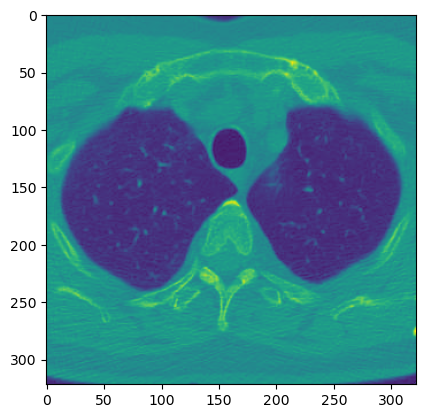

In [19]:
plt.imshow(cropped_img)

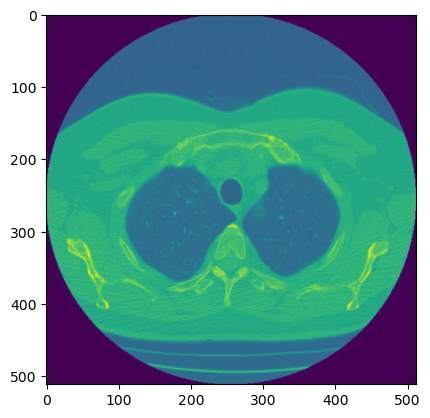

In [20]:
plt.imshow(original_image)

In [ ]:
# input_folder = r'A:\Software Projects\Segmentation\all_images\1A'
# output_folder = r'1A_crops'

# batch_process(input_folder, output_folder)

Deleted existing A:\Software Projects\Segmentation\all_images\1A


In [ ]:
# input_folder = r'A:\Software Projects\Segmentation\all_images\1G'
# output_folder = r'1G_crops'

# batch_process(input_folder, output_folder)

In [5]:
input_folder = r'A:\Software Projects\Segmentation\all_images\2A'
output_folder = r'2A_crops'

batch_process(input_folder, output_folder)

In [6]:
input_folder = r'A:\Software Projects\Segmentation\all_images\2G'
output_folder = r'2G_crops'

batch_process(input_folder, output_folder)